# AstroML
# Introduction To Making A Dense Neural Network And Evaluating Its Performance Using SDSS Data

Here we build a simple, densely connected neural network to classify RR Lyrae stars from the Sloane Digital Sky Survey, accessed through AstroML. http://www.astroml.org. There are two categories of star - variable and non-variable. The model will predict which category a star is in based on its spectrum. The two spectral characteristics of the stars which we use for this classification problem are g-r and u-g which are plotted below; they are the first two columns in the SDSS dataset which we have accessed through the astroml .fetch() function and saved as .txt files.

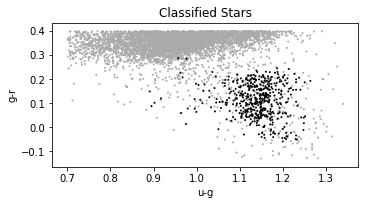

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Data_Astro = np.loadtxt('AstroML_Data.txt',dtype=float)

Labels_Astro = np.loadtxt('AstroML_Labels.txt',dtype=float)

Data_Astro = Data_Astro[:, [1, 0]]    #We select the first two columns of data: g-r and u-g

N_tot = len(Labels_Astro)       #Number of points (stars)

N_st = np.sum(Labels_Astro == 0)

N_rr = N_tot - N_st

N_plot = 5000 +N_rr

#-----------------------Plot Data------------------------------

fig = plt.figure(figsize=(5, 2.5))

fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

ax = fig.add_subplot(1, 1, 1)

im = ax.scatter(Data_Astro[-N_plot:, 1], Data_Astro[-N_plot:, 0], c=Labels_Astro[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)

im.set_clim(-0.5, 1)

plt.ylabel('g-r')

plt.xlabel('u-g')

ax.set_title('Classified Stars')

plt.show()

First, import the following modules.

In [4]:
import pandas

import sys

import scipy.io as sio

import tensorflow as tf

import sklearn

from tensorflow import keras

from sklearn.model_selection import train_test_split

import math

from keras.models import Sequential

from keras.layers.convolutional import Conv2D

from keras.layers.convolutional import MaxPooling2D

from keras.layers.core import Activation

from keras.layers.core import Flatten

from keras.layers.core import Dense

from keras import backend as K

from astroML.utils import completeness_contamination

The three functions below are used to time the training process, balance the data and make a meshgrid in which each point can be classified as a 1 (variable) or zero (non-variable) by the trained model. This meshgrid is then overlayed on the plot of stars and contour lines are added which show probabilistic regions where stars are varible or non-variable.

The data needs to be balanced as there are tens of thousands of variable stars and only 400 non-variable, which stops the model from training properly. Therefore this function duplicates the non-variable data many times so that there is a similar amount of non-variable and variable points and they are weighted approximately equally.

In [5]:
#----------------Timing fucntion---------------------------

from time import time

class TimingCallback(keras.callbacks.Callback):
    
  def __init__(self):
    
    self.logs=[]
    
  def on_epoch_begin(self, epoch, logs={}):
    
    self.starttime=time()
    
  def on_epoch_end(self, epoch, logs={}):
    
    self.logs.append(time()-self.starttime)
    
#----------------------Meshgrid--------------------------

def predictionMap(xlim,ylim):   
    
    mesh = []
    
    for x in np.arange(xlim[0],xlim[1],0.001):
        
        for y in np.arange(ylim[0],ylim[1],0.001):
            
            mesh.append([x,y])
            
    return (np.array(mesh))

#----------------Fix the weighting------------------------

def reBalanceData(x,y):
    
    filter1 = y==1
    
    ones = x[np.where(y==1)].copy()
    
    y_ones = y[np.where(y==1)].copy()
    
    total = len(y)
    
    total_one = len(ones)
    
    multiplier = math.ceil(total/total_one)
    
    for i in range(multiplier):
        
        x = np.insert(x,1,ones,axis=0)
        
        y = np.insert(y,1,y_ones,axis=0)

    ran = np.arange(x.shape[0])
    
    np.random.shuffle(ran)
    
    x= x[ran]
    
    y= y[ran]
    
    return x,y

Next, we use the reBalance function before organising the data into training and testing sets. 80% of the data is used for training and the data must be of type float32 for this particular model. 

In [6]:
Data_Astro,Labels_Astro = reBalanceData(Data_Astro,Labels_Astro)

#Split data into training and testing samples

Data_Astro,Labels_Astro = reBalanceData(Data_Astro,Labels_Astro)

X_train, X_test,y_train, y_test = train_test_split(Data_Astro, Labels_Astro,test_size=0.2, shuffle=True)

X_train = X_train.astype('float32') 

X_test = X_test.astype('float32')

# Set variables for ReBalance Function

filter1=y_train==0

y_train[filter1] = 0

filter1=y_train==1

y_train[filter1] = 1

Next, we build the model. We are using a sequential model and binary crossentropy loss function as this is a binary classification problem (stars are classified as a 1 or a 0). There are two hidden layers with widths of 8 and 20 as a large network is not needed for this problem. The final dense layer with width one contrains the output to be either a 1 or a 0. The optimization algorithm is RMSprop. Different optimization algorthms perfrom differently for different datasets and problems - usually the only way of choosing one is trial and error. When sing RMSprop for this problem the loss converges slightly quicker than with alternatives such as adam or Adadelta. 

In [8]:
#-------------------------Build model--------------------------

model = Sequential()

model.add(Dense(8, input_dim=2, kernel_initializer='normal', activation='tanh'))  #tanh -1<f<1

model.add(Dense(20, activation='tanh')) 

model.add(Dense(1, activation='sigmoid'))    #Sigmoid 0<f<1

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

The batch size, number of epochs and learning rate are specified in model.fit() but we define variables here so that they can be changed easily. We also define a variable for the training time to be stored in.

In [9]:
BS = 1000   #Set batch size

EP = 100   #Set epochs

LR = 0.01   #Set learning rate

cb = TimingCallback()

The .fit() function trains the model. It is possible to uncomment the print functions * and display the training time and loss data.
We then get the model to predict the star types of the test set and transpose the resulting array so that it can be plotted over our original graph (of pre-classified stars).

In [10]:
history = model.fit(X_train, y_train, batch_size=BS, epochs = EP)

loss_data = (history.history['loss'])

# print(loss_data) # *

# print(cb) # *

a = np.transpose(model.predict(X_test))

Epoch 1/100
299011/299011 [==============================] - 1s 2us/step - loss: 0.4047 - acc: 0.8205
Epoch 2/100
299011/299011 [==============================] - 0s 2us/step - loss: 0.0986 - acc: 0.9833
Epoch 3/100
299011/299011 [==============================] - 0s 2us/step - loss: 0.0765 - acc: 0.9848
Epoch 4/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0734 - acc: 0.9849
Epoch 5/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0693 - acc: 0.9847
Epoch 6/100
299011/299011 [==============================] - 0s 2us/step - loss: 0.0655 - acc: 0.9845
Epoch 7/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0637 - acc: 0.9844
Epoch 8/100
299011/299011 [==============================] - 1s 2us/step - loss: 0.0631 - acc: 0.9845
Epoch 9/100
299011/299011 [==============================] - ETA: 0s - loss: 0.0624 - acc: 0.984 - 0s 2us/step - loss: 0.0627 - acc: 0.9845
Epoch 10/100
299011/299011 [================

299011/299011 [==============================] - 0s 1us/step - loss: 0.0540 - acc: 0.9856
Epoch 81/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0540 - acc: 0.9856
Epoch 82/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0539 - acc: 0.9856
Epoch 83/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0538 - acc: 0.9856
Epoch 84/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0538 - acc: 0.9857
Epoch 85/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0537 - acc: 0.9857
Epoch 86/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0536 - acc: 0.9857
Epoch 87/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0536 - acc: 0.9857
Epoch 88/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.0535 - acc: 0.9857
Epoch 89/100
299011/299011 [==============================] - 0s 1us/step - loss: 0.05

Here we make a meshgrid using the predictionMap() function. The model then classifies every  point in the meshgrid as a 1 or a 0

In [11]:
#Make meshgrid same shape as plot and classify every point in grid as 1 or 0

xlim = (0.7, 1.35)

ylim = (-0.15, 0.4)

mesh = predictionMap(xlim,ylim)   #makes mesh array

xshape = int((xlim[1]-xlim[0])*1000)+1

yshape = int((ylim[1]-ylim[0])*1000)

predictions = model.predict(mesh[:,[1,0]])  #classifies points

The decision boundary is plotted over the test data using pyplot.

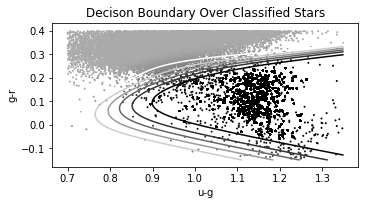

In [13]:
#Plot decision boundary

fig = plt.figure(figsize=(5, 2.5))

fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

ax = fig.add_subplot(1, 1, 1)

im = ax.scatter(X_test[:, 1], X_test[:, 0], c=a[0], s=4, lw=0, cmap=plt.cm.binary, zorder=2)

im.set_clim(-0.5, 1)

ax.contour(np.reshape(mesh[:,0], (xshape, yshape)), np.reshape(mesh[:,1],(xshape,yshape)), np.reshape(predictions,(xshape,yshape)), cmap=plt.cm.binary)

plt.ylabel('g-r')

plt.xlabel('u-g')

ax.set_title('Decison Boundary Over Classified Stars')

plt.show()

We evaluate the performance of the model by plotting the accuracy and the loss against epoch number. It is possible to see which data is stored in history using the history.keys() function * and plot other parameters to demonstrate model performance.

dict_keys(['acc', 'loss'])


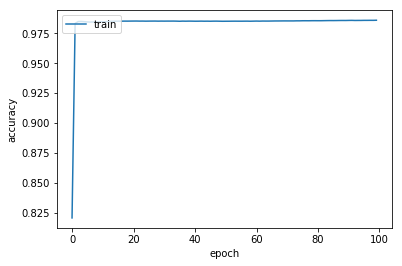

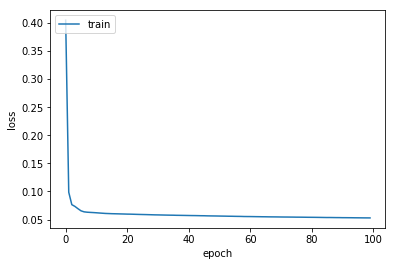

In [14]:
#Evaluate Perforamce


# * print(history.history.keys()) * #


# plot accuracy vs epoch

plt.plot(history.history['acc'])

ax.set_title('model accuracy')

plt.ylabel('accuracy')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')

plt.show()

# plot loss vs epoch

plt.plot(history.history['loss'])

ax.set_title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc = 'upper left')

plt.show()

The performance of the model can be changed by adjusting the learning rate, optimizer, loss function, number of epochs and batch size.